In text mining projects, one important part is preprocessing which can be divided into:
- Noise-removal. Usually raw texts are messy to certain extent, particularly the texts from social media which include many urls, hashtags, typos, abbreviations, emoji, punctuation and deliberatelly misspellings. These symbols seems not contain much useful information, but we do know that many times punctuation can affect the sentiment and meaning of a sentence. 
- Normalization. Stemmize and lemmatize the words, for example, replace "am, is ,are" with the root "be". This method can reduce the size of vocabulary. Further normalizations may include replace abbreviations with full letters, map capital words into lower cases.
- Tokenization. Usually a text is stored as a long string, which can not be handled by a computer straightforward. An article consists of paragraphs, and a paragraph consists of sentences, and a sentence consists of words. The basic elements of a sentence are words. We need to tokenize texts into sequences of words to analyse semantics, syntactics and etc.

For more information, we can refer to the course https://www.coursera.org/learn/language-processing, which covers fundamental knowledge and skills of current NLP. Three most popular NLP tools are Spacy, NLTK and Textblob, all of which provide functions such as tokenization,lemmatization, even sentiment analysis training and testing.

Preprocessing methods can affect performances of classification models because different methods can produce different vocabulary, then different representation of texts.

Each specific dataset has its own characteristics, for example, some are quite clean, some are very messy, consequently there are no universal ideal preprocessing methods that can do well for each dataset. Most current methods are based on empirical results.

In this project, we aimed to check whether punctuation matters in sentiment analysis. We designed three groups of experiment:
- Applied vectorizer on the raw texts without removing puctuation;
- Applied vectorizer on the texts that had beed removed punctuation;
- Applied vectorizer on the texts that had been lemmatized in word-level.

We used IMDB dataset downloaded from http://ai.stanford.edu/~amaas/data/sentiment/ . And we compared performances of Logistic Regression, Naive Bayes.

In [1]:
from gensim import utils
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

## Get Data

In [13]:
train_data = pd.read_csv('data/train.csv', header=None, names=['label', 'text'])
test_data = pd.read_csv('data/test.csv', header=None, names=['label', 'text'])

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
label    25000 non-null int64
text     25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


In [17]:
train_texts = train_data.text
train_labels = train_data.label
test_texts = test_data.text
test_labels = test_data.label

In [18]:
train_texts[0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

In [19]:
sum(train_labels)

12500

In [20]:
#shuffle the data
data = list(zip(train_texts, train_labels))
np.random.shuffle(data)

In [21]:
train_texts, train_labels = zip(*data)

## Explore Data

In [69]:
word_lens = [len(item.split()) for item in train_texts]

In [78]:
sum(np.array(word_lens) > 1000)

106

In [70]:
np.percentile(word_lens, [0, 25, 50, 75, 95])

array([  10.,  129.,  177.,  287.,  608.])

Text(0.5,1,'Text Length')

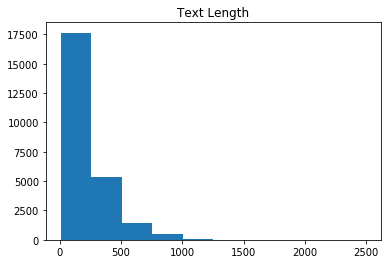

In [73]:
plt.hist(word_lens)
plt.title('Text Length')

In [31]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.3, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## TfIdf+Unigram+Logistic Regression

### Logistic Regression

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [56]:
from sklearn.linear_model import LogisticRegression
train_accuracy = []
test_accuracy = []
parameters = np.arange(0.5, 3, 0.5)
for c in parameters:
    classifier = LogisticRegression(C=c)
    classifier.fit(X_train, train_labels)
    train_score = classifier.score(X_train, train_labels)
    test_score = classifier.score(X_test, test_labels)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)

In [57]:
max(test_accuracy)

0.88683999999999996

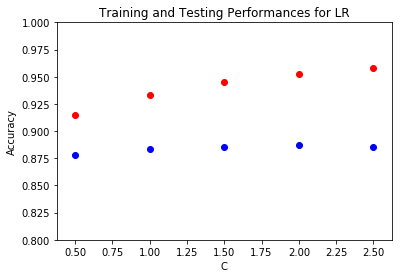

In [58]:
plt.scatter(parameters, train_accuracy, c='r')
plt.scatter(parameters, test_accuracy, c='b')
plt.title('Training and Testing Performances for LR')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.show()

<module 'matplotlib.pyplot' from '/Users/richardsun/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

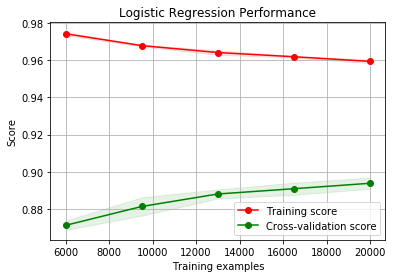

In [59]:
plot_learning_curve(estimator=classifier, title='Logistic Regression Performance',
                    X=X_train, y=train_labels, cv=5)

In [63]:
from sklearn.naive_bayes import MultinomialNB
train_accuracy = []
test_accuracy = []
parameters = np.arange(0.1, 3, 0.2)
for c in parameters:
    classifier = MultinomialNB(alpha=c)
    classifier.fit(X_train, train_labels)
    train_score = classifier.score(X_train, train_labels)
    test_score = classifier.score(X_test, test_labels)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)

In [64]:
max(test_accuracy)

0.83176000000000005

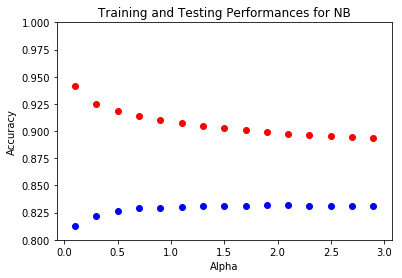

In [65]:
plt.scatter(parameters, train_accuracy, c='r')
plt.scatter(parameters, test_accuracy, c='b')
plt.title('Training and Testing Performances for NB')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.show()

### Randomforest

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
parameters = {'max_depth':[2, 3, 4, 5, 6, 7, 8], 
              'n_estimators':[10, 20, 30 ,40, 50]}
rf = RandomForestClassifier(n_jobs=4)
gridsearch = GridSearchCV(rf, parameters, cv=5)

In [37]:
gridsearch.fit(X_train, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8], 'n_estimators': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
gridsearch.score(X_test, test_labels)

0.80259999999999998

### Lightgbm

In [134]:
import lightgbm as lgb
train_lgbdata = lgb.Dataset(X_train, label=np.array(train_labels))
test_lgbdata = lgb.Dataset(X_test, label=test_labels.values)

In [161]:
param = {'num_leaves':80, 'num_iterations':500, 'objective':'binary'}
param['metric'] = 'auc'
num_round = 30
bst = lgb.train(param, train_lgbdata, num_round, valid_sets=[test_lgbdata])

/Users/richardsun/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.813993
[2]	valid_0's auc: 0.829287
[3]	valid_0's auc: 0.836596
[4]	valid_0's auc: 0.843293
[5]	valid_0's auc: 0.84843
[6]	valid_0's auc: 0.854426
[7]	valid_0's auc: 0.857174
[8]	valid_0's auc: 0.859592
[9]	valid_0's auc: 0.862892
[10]	valid_0's auc: 0.865627
[11]	valid_0's auc: 0.869521
[12]	valid_0's auc: 0.872408
[13]	valid_0's auc: 0.8771
[14]	valid_0's auc: 0.879394
[15]	valid_0's auc: 0.88181
[16]	valid_0's auc: 0.884037
[17]	valid_0's auc: 0.886284
[18]	valid_0's auc: 0.888357
[19]	valid_0's auc: 0.890658
[20]	valid_0's auc: 0.892727
[21]	valid_0's auc: 0.895161
[22]	valid_0's auc: 0.89682
[23]	valid_0's auc: 0.89888
[24]	valid_0's auc: 0.900734
[25]	valid_0's auc: 0.90216
[26]	valid_0's auc: 0.903557
[27]	valid_0's auc: 0.905345
[28]	valid_0's auc: 0.906611
[29]	valid_0's auc: 0.907748
[30]	valid_0's auc: 0.909167
[31]	valid_0's auc: 0.910515
[32]	valid_0's auc: 0.911836
[33]	valid_0's auc: 0.91311
[34]	valid_0's auc: 0.914072
[35]	valid_0's auc: 0.915107
[3

In [162]:
from sklearn.metrics import accuracy_score
ypred = bst.predict(X_test) > 0.5
accuracy_score(ypred, test_labels)

0.88292000000000004

### TfIdf+Unigram+bigram+trigram

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1, 3))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [71]:
from sklearn.linear_model import LogisticRegression
train_accuracy = []
test_accuracy = []
parameters = np.arange(0.5, 3, 0.5)
for c in parameters:
    classifier = LogisticRegression(C=c)
    classifier.fit(X_train, train_labels)
    train_score = classifier.score(X_train, train_labels)
    test_score = classifier.score(X_test, test_labels)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)

In [72]:
max(test_accuracy)

0.90195999999999998

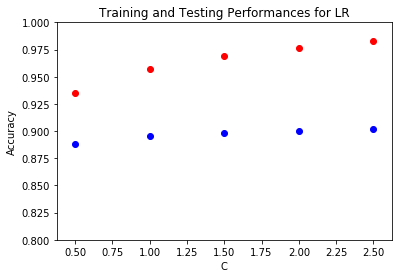

In [74]:
plt.scatter(parameters, train_accuracy, c='r')
plt.scatter(parameters, test_accuracy, c='b')
plt.title('Training and Testing Performances for LR')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.show()

## Character n-gram

In [79]:
#from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(2, 5), analyzer='char')
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [80]:
from sklearn.linear_model import LogisticRegression
train_accuracy = []
test_accuracy = []
parameters = np.arange(0.5, 3, 0.5)
for c in parameters:
    classifier = LogisticRegression(C=c)
    classifier.fit(X_train, train_labels)
    train_score = classifier.score(X_train, train_labels)
    test_score = classifier.score(X_test, test_labels)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)

In [81]:
max(test_accuracy)

0.89583999999999997